# Plotting and analyzing 16S rRNA amplicon sequencing results

In [1]:
#Load necessary libaries
import pandas as pd
import matplotlib.pyplot as plt
from skbio.diversity import alpha_diversity
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.spatial.distance import pdist, squareform
from skbio import DistanceMatrix
from skbio.stats.distance import anosim, permanova
from skbio.stats.ordination import pcoa
import seaborn as sn

### OTU table and taxonomy table pre-processing

In [2]:
#Load and clean zotu taxonomy file
zotu_tax = pd.read_csv('data/zotu_taxonomy_rdp_nbc.txt', sep='\t', header=None)
zotu_tax = zotu_tax.drop(2, axis=1)
zotu_tax = zotu_tax.set_index(zotu_tax.loc[:,0])
zotu_tax = zotu_tax.drop(0, axis=1)
zotu_tax = zotu_tax.rename(columns={1:'tax_with_conf',3:'tax'})
zotu_tax

,tax_with_conf,tax
0,,
Zotu4,"d:Bacteria(1.0000),p:Proteobacteria(1.0000),c:...","d:Bacteria,p:Proteobacteria,c:Betaproteobacter..."
Zotu1,"d:Bacteria(1.0000),p:Proteobacteria(1.0000),c:...","d:Bacteria,p:Proteobacteria,c:Alphaproteobacte..."
Zotu2,"d:Bacteria(1.0000),p:Proteobacteria(1.0000),c:...","d:Bacteria,p:Proteobacteria,c:Betaproteobacter..."
Zotu7,"d:Bacteria(1.0000),p:Proteobacteria(1.0000),c:...","d:Bacteria,p:Proteobacteria,c:Alphaproteobacte..."
Zotu5,"d:Bacteria(0.9900),p:Omnitrophica(0.2500),g:Om...",d:Bacteria
...,...,...
Zotu8345,"d:Bacteria(1.0000),p:Acidobacteria(0.9500),c:A...","d:Bacteria,p:Acidobacteria,c:Acidobacteria_Gp10"
Zotu8347,"d:Bacteria(1.0000),p:Bacteroidetes(0.3200),c:B...",d:Bacteria
Zotu8348,"d:Bacteria(1.0000),p:Chloroflexi(1.0000),c:Ana...","d:Bacteria,p:Chloroflexi,c:Anaerolineae,o:Anae..."


In [3]:
#Filter out Zotus with less than 95% confidence at the domain level as they are likely contaminating sequence
domain_conf = zotu_tax.tax_with_conf.str.split(',', expand=True)[0].str.slice(-7,-1)
zotu_tax = zotu_tax[pd.to_numeric(domain_conf)>0.95]

In [4]:
#Load read mapping otu tab file for each sample subset and combine to single table
otu_tab = pd.read_csv("data/soil_zotutab2.txt", sep='\t', index_col=0)
otu_tab = otu_tab.join(pd.read_csv("data/low_zotutab2.txt", sep='\t', index_col=0), how='outer')
otu_tab = otu_tab.join(pd.read_csv("data/high_zotutab2.txt", sep='\t', index_col=0), how='outer')
otu_tab.fillna(0, inplace=True)
otu_tab = otu_tab.reindex(sorted(otu_tab.columns), axis=1)
otu_tab = otu_tab.reindex(sorted(otu_tab.index), axis=0)
otu_tab.sort_values(by="YK-8", ascending=False)

,YK-1,YK-2,YK-3,YK-4,YK-5,YK-6,YK-7,YK-8,YK-9
#OTU ID,,,,,,,,,
Zotu3,0.0,0.0,0.0,765.0,568.0,442.0,293.0,174437.0,1939.0
Zotu11,20.0,0.0,2.0,976.0,587.0,215.0,528.0,63802.0,6965.0
Zotu14,0.0,0.0,0.0,280.0,235.0,175.0,110.0,51866.0,674.0
Zotu16,0.0,0.0,0.0,239.0,191.0,138.0,100.0,47557.0,695.0
Zotu18,0.0,0.0,0.0,265.0,203.0,113.0,82.0,39642.0,665.0
...,...,...,...,...,...,...,...,...,...
Zotu3668,15.0,21.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0
Zotu3667,17.0,47.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0
Zotu3666,12.0,39.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#Filter out bad zotus from the otu table
otu_tab = otu_tab.loc[zotu_tax.index]
otu_tab.columns=['Soil-1','Soil-2','Soil-3','High-1','High-2','High-3','Low-1','Low-2','Low-3']
otu_tab

,Soil-1,Soil-2,Soil-3,High-1,High-2,High-3,Low-1,Low-2,Low-3
0,,,,,,,,,
Zotu4,4.0,0.0,0.0,63679.0,11090.0,9774.0,46965.0,2828.0,5955.0
Zotu1,494.0,834.0,545.0,302548.0,418240.0,307642.0,3044.0,15434.0,23328.0
Zotu2,19.0,10.0,15.0,46678.0,209929.0,112595.0,3119.0,22996.0,12836.0
Zotu7,51.0,140.0,119.0,15895.0,26435.0,41917.0,1665.0,1255.0,2166.0
Zotu5,193.0,1.0,2.0,619.0,526.0,360.0,230.0,911.0,110030.0
...,...,...,...,...,...,...,...,...,...
Zotu8345,3.0,26.0,10.0,0.0,0.0,0.0,0.0,0.0,1.0
Zotu8347,2.0,9.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0
Zotu8348,5.0,9.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#Normalize OTU table by total counts
norm_otu_tab = otu_tab/otu_tab.sum(axis=0)*100
norm_otu_tab.sort_values(by="High-1", ascending=False).head(20)

,Soil-1,Soil-2,Soil-3,High-1,High-2,High-3,Low-1,Low-2,Low-3
0,,,,,,,,,
Zotu1,0.164073,0.182842,0.122422,49.405997,46.750837,46.697612,0.505621,2.048550,3.840986
Zotu4,0.001329,0.000000,0.000000,10.398762,1.239639,1.483616,7.801080,0.375360,0.980499
Zotu2,0.006310,0.002192,0.003369,7.622503,23.465848,17.091027,0.518079,3.052252,2.113465
Zotu7,0.016939,0.030693,0.026731,2.595649,2.954902,6.362668,0.276563,0.166576,0.356635
Zotu50,0.060780,0.065551,0.097264,1.555430,0.011513,0.044020,0.002990,0.012344,0.058616
Zotu62,0.001329,0.000658,0.000674,1.389027,0.177618,0.194749,0.049333,0.013273,0.023710
Zotu21,0.000000,0.000658,0.000000,1.037606,2.313062,1.856872,0.009966,0.082292,0.071459
Zotu88,0.002325,0.008112,0.006065,0.994169,0.005924,0.021251,0.002658,0.006504,0.019758
Zotu17,0.068751,0.096464,0.128038,0.909416,1.185203,0.298271,1.300097,2.459481,0.188526


In [7]:
#Combine normalized OTU table and taxonomy into table for export
combined = pd.concat([zotu_tax, norm_otu_tab], axis=1)
combined.to_csv("output/normalized_otu_w_taxonomy.csv")

In [8]:
#Split taxonomy assignmnents into different levels for plotting
split_tax = combined.tax.str.split(',', expand=True).fillna('Unclassified').rename(columns={0:'d',1:'p',2:'c',3:'o',4:'f',5:'g'})
split_tax

,d,p,c,o,f,g
0,,,,,,
Zotu4,d:Bacteria,p:Proteobacteria,c:Betaproteobacteria,o:Nitrosomonadales,f:Sterolibacteriaceae,g:Methyloversatilis
Zotu1,d:Bacteria,p:Proteobacteria,c:Alphaproteobacteria,o:Rhizobiales,f:Methylocystaceae,g:Methylocystis
Zotu2,d:Bacteria,p:Proteobacteria,c:Betaproteobacteria,o:Burkholderiales,f:Comamonadaceae,g:Aquabacterium
Zotu7,d:Bacteria,p:Proteobacteria,c:Alphaproteobacteria,o:Rhizobiales,f:Hyphomicrobiaceae,g:Hyphomicrobium
Zotu5,d:Bacteria,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified
...,...,...,...,...,...,...
Zotu8345,d:Bacteria,p:Acidobacteria,c:Acidobacteria_Gp10,Unclassified,Unclassified,Unclassified
Zotu8347,d:Bacteria,Unclassified,Unclassified,Unclassified,Unclassified,Unclassified
Zotu8348,d:Bacteria,p:Chloroflexi,c:Anaerolineae,o:Anaerolineales,f:Anaerolineaceae,Unclassified


### Taxonomy stacked bar plots

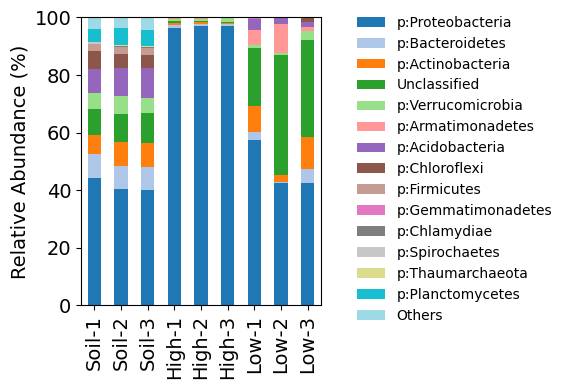

In [10]:
x = norm_otu_tab.join(split_tax, how='outer').groupby('p').sum()
x = x.sort_values(by='High-1', ascending=False).head(14)
others = 100 - x.sum()
x.loc['Others'] = others
x.T.plot.bar(stacked=True, cmap='tab20', figsize=(6,4))
plt.legend(bbox_to_anchor=(1.1,1.05),fontsize=10, frameon=False)
#plt.title('Phylum-level Taxonomic Abundance', size=18)
plt.ylabel('Relative Abundance (%)', size=14)
plt.xticks(rotation=90,size=14)
plt.yticks(size=14)
plt.ylim([0,100])
plt.tight_layout()
plt.savefig('figures/Phlyum_rel_abundance_v4_nbc_rdp.png',dpi=300)

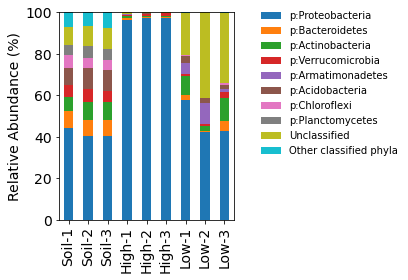

In [19]:
x = norm_otu_tab.join(split_tax, how='outer').groupby('p').sum()
x = x.loc[['p:Proteobacteria','p:Bacteroidetes','p:Actinobacteria','p:Verrucomicrobia','p:Armatimonadetes','p:Acidobacteria','p:Chloroflexi','p:Planctomycetes','Unclassified']]
others = 100 - x.sum()
x.loc['Other classified phyla'] = others
x.T.plot.bar(stacked=True, cmap='tab10', figsize=(6,4))
plt.legend(bbox_to_anchor=(1.1,1.05),fontsize=10, frameon=False)
#plt.title('Phylum-level Taxonomic Abundance', size=18)
plt.ylabel('Relative Abundance (%)', size=14)
plt.xticks(rotation=90,size=14)
plt.yticks(size=14)
plt.ylim([0,100])
plt.tight_layout()
plt.savefig('figures/Phlyum_rel_abundance_v5_nbc_rdp.png',dpi=300)

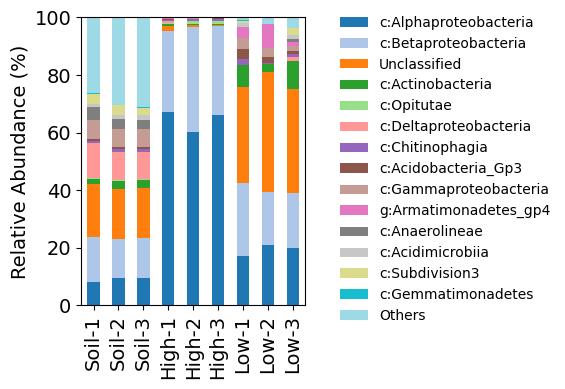

In [11]:
x = norm_otu_tab.join(split_tax, how='outer').groupby('c').sum()
x = x.sort_values(by='High-1', ascending=False).head(14)
others = 100 - x.sum()
x.loc['Others'] = others
x.T.plot.bar(stacked=True, cmap='tab20', figsize=(6,4))
plt.legend(bbox_to_anchor=(1.1,1.05),fontsize=10, frameon=False)
plt.ylabel('Relative Abundance (%)', size=14)
plt.xticks(rotation=90,size=14)
plt.yticks(size=14)
plt.ylim([0,100])
plt.tight_layout()
plt.savefig('figures/Class_rel_abundance_v4_nbc_rdp.png',dpi=300)

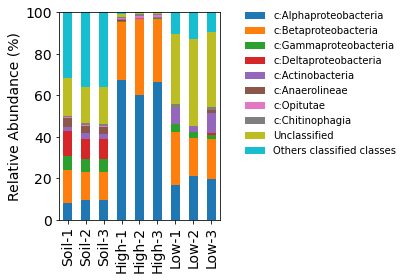

In [18]:
x = norm_otu_tab.join(split_tax, how='outer').groupby('c').sum()
x = x.loc[['c:Alphaproteobacteria','c:Betaproteobacteria','c:Gammaproteobacteria','c:Deltaproteobacteria','c:Actinobacteria','c:Anaerolineae','c:Opitutae','c:Chitinophagia','Unclassified']]
others = 100 - x.sum()
x.loc['Others classified classes'] = others
x.T.plot.bar(stacked=True, cmap='tab10', figsize=(6,4))
plt.legend(bbox_to_anchor=(1.1,1.05),fontsize=10, frameon=False)
plt.ylabel('Relative Abundance (%)', size=14)
plt.xticks(rotation=90,size=14)
plt.yticks(size=14)
plt.ylim([0,100])
plt.tight_layout()
plt.savefig('figures/Class_rel_abundance_v5_nbc_rdp.png',dpi=300)

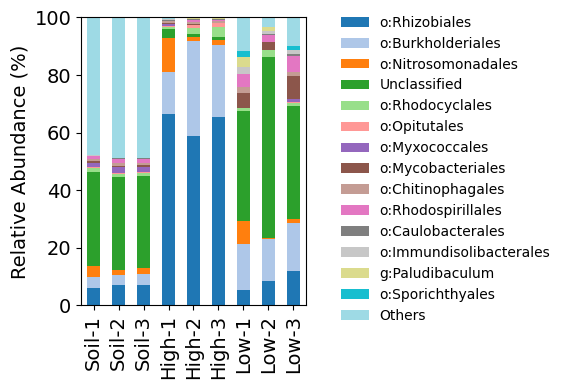

In [12]:
x = norm_otu_tab.join(split_tax, how='outer').groupby('o').sum()
x = x.sort_values(by='High-1', ascending=False).head(14)
others = 100 - x.sum()
x.loc['Others'] = others
x.T.plot.bar(stacked=True, cmap='tab20', figsize=(6,4))
plt.legend(bbox_to_anchor=(1.1,1.05),fontsize=10, frameon=False)
plt.ylabel('Relative Abundance (%)', size=14)
plt.xticks(rotation=90,size=14)
plt.yticks(size=14)
plt.ylim([0,100])
plt.tight_layout()
plt.savefig('figures/Order_rel_abundance_v4_nbc_rdp.png',dpi=300)

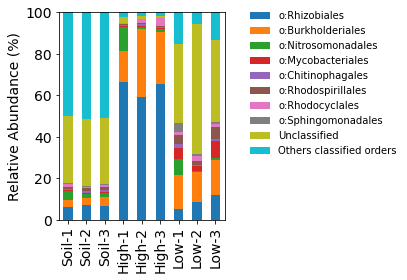

In [20]:
x = norm_otu_tab.join(split_tax, how='outer').groupby('o').sum()
x = x.loc[['o:Rhizobiales','o:Burkholderiales','o:Nitrosomonadales','o:Mycobacteriales','o:Chitinophagales','o:Rhodospirillales','o:Rhodocyclales','o:Sphingomonadales','Unclassified']]
others = 100 - x.sum()
x.loc['Others classified orders'] = others
x.T.plot.bar(stacked=True, cmap='tab10', figsize=(6,4))
plt.legend(bbox_to_anchor=(1.1,1.05),fontsize=10, frameon=False)
plt.ylabel('Relative Abundance (%)', size=14)
plt.xticks(rotation=90,size=14)
plt.yticks(size=14)
plt.ylim([0,100])
plt.tight_layout()
plt.savefig('figures/Order_rel_abundance_v5_nbc_rdp.png',dpi=300)

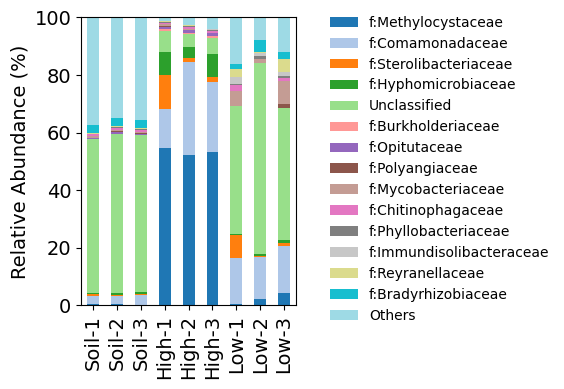

In [13]:
x = norm_otu_tab.join(split_tax, how='outer').groupby('f').sum()
x = x.sort_values(by='High-1', ascending=False).head(14)
others = 100 - x.sum()
x.loc['Others'] = others
x.T.plot.bar(stacked=True, cmap='tab20', figsize=(6,4))
plt.legend(bbox_to_anchor=(1.1,1.05),fontsize=10, frameon=False)
plt.ylabel('Relative Abundance (%)', size=14)
plt.xticks(rotation=90,size=14)
plt.yticks(size=14)
plt.ylim([0,100])
plt.tight_layout()
plt.savefig('figures/Family_rel_abundance_v4_nbc_rdp.png',dpi=300)

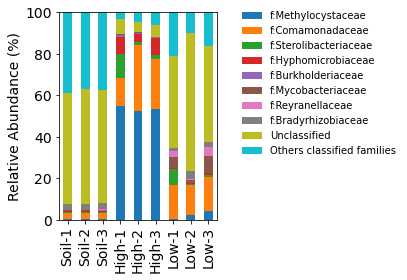

In [22]:
x = norm_otu_tab.join(split_tax, how='outer').groupby('f').sum()
x = x.loc[['f:Methylocystaceae','f:Comamonadaceae','f:Sterolibacteriaceae','f:Hyphomicrobiaceae','f:Burkholderiaceae','f:Mycobacteriaceae','f:Reyranellaceae','f:Bradyrhizobiaceae','Unclassified']]
others = 100 - x.sum()
x.loc['Others classified families'] = others
x.T.plot.bar(stacked=True, cmap='tab10', figsize=(6,4))
plt.legend(bbox_to_anchor=(1.1,1.05),fontsize=10, frameon=False)
plt.ylabel('Relative Abundance (%)', size=14)
plt.xticks(rotation=90,size=14)
plt.yticks(size=14)
plt.ylim([0,100])
plt.tight_layout()
plt.savefig('figures/Family_rel_abundance_v5_nbc_rdp.png',dpi=300)

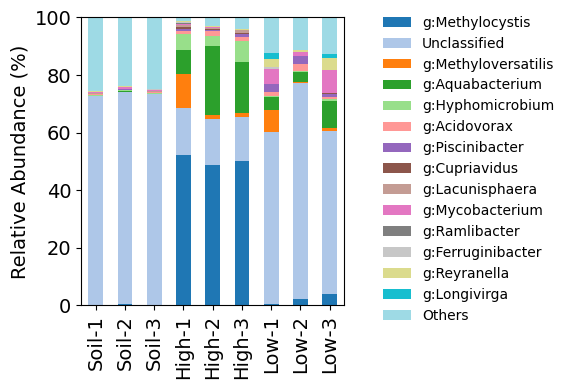

In [14]:
x = norm_otu_tab.join(split_tax, how='outer').groupby('g').sum()
x = x.sort_values(by='High-1', ascending=False).head(14)
others = 100 - x.sum()
x.loc['Others'] = others
x.T.plot.bar(stacked=True, cmap='tab20', figsize=(6,4))
plt.legend(bbox_to_anchor=(1.1,1.05),fontsize=10, frameon=False)
plt.ylabel('Relative Abundance (%)', size=14)
plt.xticks(rotation=90,size=14)
plt.yticks(size=14)
plt.ylim([0,100])
plt.tight_layout()
plt.savefig('figures/Genus_rel_abundance_v4_nbc_rdp.png',dpi=300)

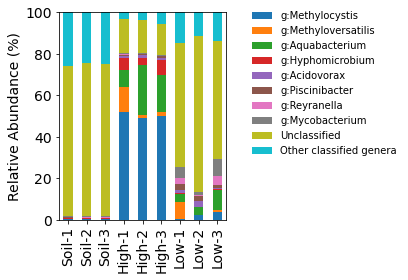

In [16]:
x = norm_otu_tab.join(split_tax, how='outer').groupby('g').sum()
x = x.loc[['g:Methylocystis','g:Methyloversatilis','g:Aquabacterium','g:Hyphomicrobium','g:Acidovorax','g:Piscinibacter','g:Reyranella','g:Mycobacterium','Unclassified']]
others = 100 - x.sum()
x.loc['Other classified genera'] = others
x.T.plot.bar(stacked=True, cmap='tab10', figsize=(6,4))
plt.legend(bbox_to_anchor=(1.1,1.05),fontsize=10, frameon=False)
plt.ylabel('Relative Abundance (%)', size=14)
plt.xticks(rotation=90,size=14)
plt.yticks(size=14)
plt.ylim([0,100])
plt.tight_layout()
plt.savefig('figures/Genus_rel_abundance_v5_nbc_rdp.png',dpi=300)

### Alpha-diversity analysis

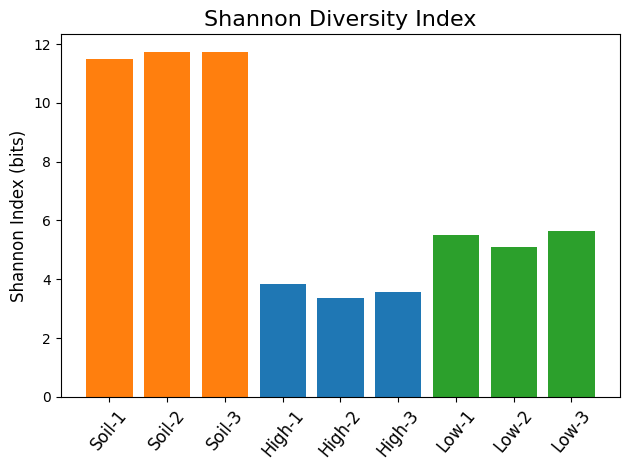

In [15]:
#Plot shannon diversity
plt.bar(np.arange(0,len(otu_tab.columns)),alpha_diversity('shannon',otu_tab.T),
       color=['tab:orange','tab:orange','tab:orange','tab:blue','tab:blue','tab:blue'
              ,'tab:green','tab:green','tab:green'])
plt.title('Shannon Diversity Index', size=16)
plt.xticks(ticks=np.arange(0,len(otu_tab.columns)),labels=otu_tab.columns, rotation=50,size=12)
plt.ylabel('Shannon Index (bits)', size=12)
#plt.xlabel('Sample')
plt.tight_layout()
plt.savefig('figures/Shannon_Diversity_colors.png',dpi=300)

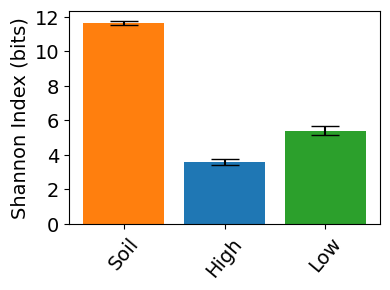

In [16]:
#Plot shannon diversity as mean and std of groups
alpha = alpha_diversity('shannon',otu_tab.T)
soil_mean = np.mean(alpha[0:3])
soil_std = np.std(alpha[0:3])
high_mean = np.mean(alpha[3:6])
high_std = np.std(alpha[3:6])
low_mean = np.mean(alpha[6:9])
low_std = np.std(alpha[6:9])
plt.figure(figsize=(4,3))
plt.bar(np.arange(0,3),[soil_mean, high_mean, low_mean], yerr=[soil_std,high_std,low_std],
       capsize=10., color=['tab:orange','tab:blue','tab:green'])
#plt.title('Shannon Diversity Index', size=16)
plt.xticks(ticks=np.arange(0,3),labels=['Soil','High','Low'], rotation=50, size=14)
plt.yticks(size=14)
plt.ylabel('Shannon Index (bits)', size=14)
plt.tight_layout()
plt.savefig('figures/Shannon_Diversity_mean_color_v2.png',dpi=300)

In [17]:
#ANOVA and post-hoc tests on shannon diversity data
soil_div = alpha_diversity('shannon',otu_tab.T)[0:3]
high_div = alpha_diversity('shannon',otu_tab.T)[3:6]
low_div = alpha_diversity('shannon',otu_tab.T)[6:9]

print(f_oneway(soil_div, high_div, low_div))

F_onewayResult(statistic=971.9304967804587, pvalue=2.9136863331549842e-08)


In [18]:
df = pd.DataFrame({'div': alpha_diversity('shannon', otu_tab.T),
                   'group': np.repeat(['soil', 'high', 'low'], repeats=3)})
print(pairwise_tukeyhsd(endog=df['div'],
                          groups=df['group'],
                          alpha=0.05))

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
  high    low   1.8304 0.001 1.2427 2.4181   True
  high   soil   8.0638 0.001 7.4761 8.6515   True
   low   soil   6.2334 0.001 5.6457 6.8211   True
-------------------------------------------------


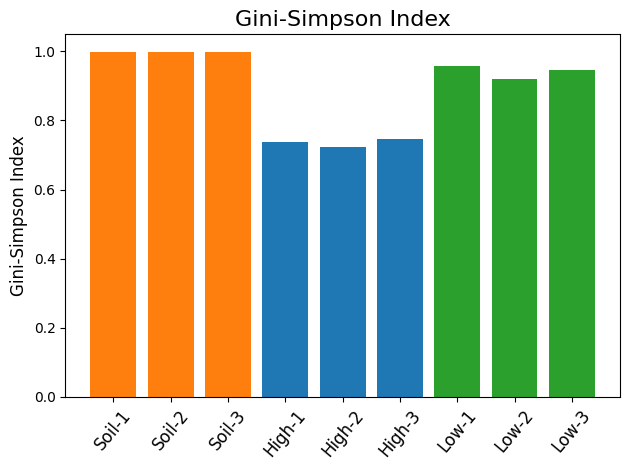

In [19]:
#Plot Gini-Simpson alpha diversity
plt.bar(np.arange(0,len(otu_tab.columns)),alpha_diversity('simpson',otu_tab.T),
        color=['tab:orange','tab:orange','tab:orange','tab:blue','tab:blue','tab:blue'
              ,'tab:green','tab:green','tab:green'])
plt.title('Gini-Simpson Index', size=16)
plt.xticks(ticks=np.arange(0,len(otu_tab.columns)),labels=otu_tab.columns, rotation=50, size=12)
plt.ylabel('Gini-Simpson Index', size=12)
plt.tight_layout()
plt.savefig('figures/Gini-Simpson_Diversity_colors.png',dpi=300)

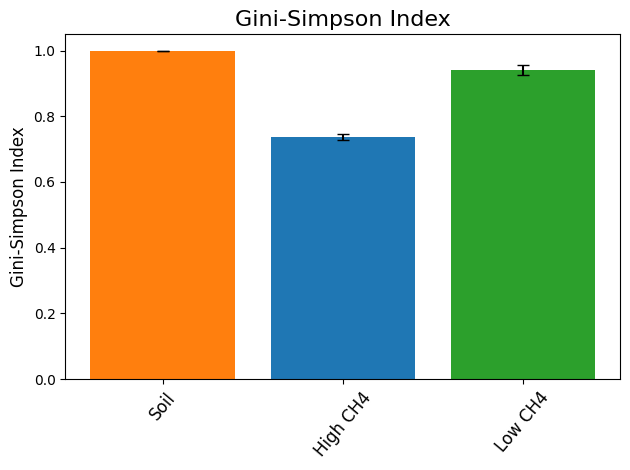

In [20]:
#Plot Gini-Simpson as mean and std of groups
alpha = alpha_diversity('simpson',otu_tab.T)
soil_mean = np.mean(alpha[0:3])
soil_std = np.std(alpha[0:3])
high_mean = np.mean(alpha[3:6])
high_std = np.std(alpha[3:6])
low_mean = np.mean(alpha[6:9])
low_std = np.std(alpha[6:9])
plt.bar(np.arange(0,3),[soil_mean, high_mean, low_mean], yerr=[soil_std,high_std,low_std],
       capsize=4., color=['tab:orange','tab:blue','tab:green'])
plt.title('Gini-Simpson Index', size=16)
plt.xticks(ticks=np.arange(0,3),labels=['Soil','High CH4','Low CH4'], rotation=50, size=12)
plt.ylabel('Gini-Simpson Index', size=12)
#plt.xlabel('Sample Group')
plt.tight_layout()
plt.savefig('figures/Gini-Simpson-Index_mean_color.png',dpi=300)

### Perform Ordination on OTU table

In [24]:
#Compute distance matrix
dist = pdist(norm_otu_tab.T, metric='braycurtis')
square_dist = squareform(dist)
dm = DistanceMatrix(square_dist)
labels = np.repeat(['soil','high','low'],3)
#run anosim to compare conditions
anosim(dm, labels, permutations=9999)

method name                 ANOSIM
test statistic name              R
sample size                      9
number of groups                 3
test statistic            0.983539
p-value                     0.0051
number of permutations        9999
Name: ANOSIM results, dtype: object

In [25]:
#run permanova to compare conditions
permanova(dm, labels, permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                       9
number of groups                  3
test statistic             9.196346
p-value                      0.0047
number of permutations         9999
Name: PERMANOVA results, dtype: object

In [26]:
#Compute PCoA on distance matrix
pcoa_df = pcoa(square_dist, number_of_dimensions=2).samples
pcoa_df['group'] = list(labels)
print("PCoA Proportion Explained")
pcoa(square_dist, number_of_dimensions=2).proportion_explained

PCoA Proportion Explained


PC1    0.483326
PC2    0.273845
dtype: float64

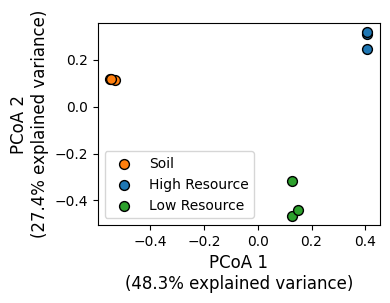

In [27]:
plt.figure(figsize=(4,3))
plt.scatter(pcoa_df.iloc[0:3, 0], pcoa_df.iloc[0:3, 1], color='tab:orange', label='Soil', s=50, edgecolors='black')
plt.scatter(pcoa_df.iloc[3:6, 0], pcoa_df.iloc[3:6, 1], color='tab:blue', label='High Resource',  s=50, edgecolors='black')
plt.scatter(pcoa_df.iloc[6:9, 0], pcoa_df.iloc[6:9, 1], color='tab:green', label='Low Resource',  s=50, edgecolors='black')
#plt.title('PCoA of OTU Table', size=16)
plt.legend(fontsize=10)
plt.xlabel('PCoA 1\n(48.3% explained variance)', size=12)
plt.ylabel('PCoA 2\n(27.4% explained variance)', size=12)
plt.tight_layout()
plt.savefig('figures/PCoA_v2.png', dpi=300)